#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *


from keras.models import Sequential , Model
from keras.layers import Dense, Flatten, Dropout , Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')

In [ ]:
data01_train.drop('subject', axis=1, inplace=True)
data01_test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
data01_train['is_dynamic'] = np.where(((data01_train['Activity']=='STANDING')|(data01_train['Activity']=='SITTING')|(data01_train['Activity']=='LAYING')),
                              0,1)
data01_test['is_dynamic'] = np.where(((data01_test['Activity']=='STANDING')|(data01_test['Activity']=='SITTING')|(data01_test['Activity']=='LAYING')),
                              0,1)

In [ ]:
data01_test

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,1
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,SITTING,0
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,STANDING,0
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,WALKING_DOWNSTAIRS,1
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,LAYING,0


In [ ]:
data01_train_1=data01_train.drop('Activity',axis=1)
data01_test_1=data01_test.drop('Activity',axis=1)

### (2) x, y 분리

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
x = data01_train_1.drop('is_dynamic',axis=1)
y = data01_train_1['is_dynamic']

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=72)

In [ ]:
nfeatures = x_train.shape[1]

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [ ]:
result={}

In [ ]:
clear_session()
io = Input(shape=(nfeatures,))
ot = Dense(1,activation='sigmoid')(io)

model1 = Model(inputs=io,outputs=ot)
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 561)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 562 (2.20 KB)

 Trainable params: 562 (2.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
history1 = model1.fit(x_train,y_train,epochs=100,validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6661 - val_loss: 0.4996
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4597 - val_loss: 0.3574
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3336 - val_loss: 0.2688
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2530 - val_loss: 0.2102
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1978 - val_loss: 0.1700
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1639 - val_loss: 0.1411
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1364 - val_loss: 0.1197
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1143 - val_loss: 0.1031
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0979 - val_loss: 0.0901
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0861 - val_loss: 0.0796
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0761 - val_loss: 0.0710
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

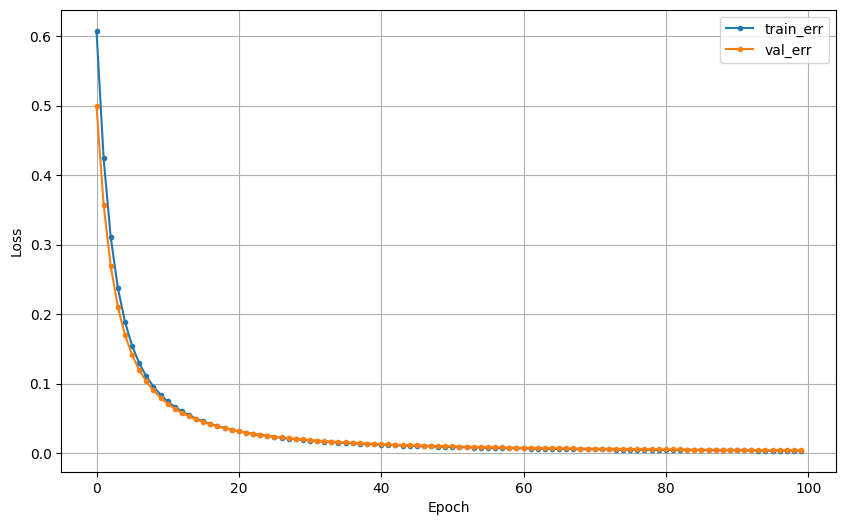

In [ ]:
dl_history_plot(history1)

In [ ]:
pred1 = model1.predict(x_val)
pred1 = np.where(pred1>=0.5,1,0)
print(confusion_matrix(y_val,pred1))
print(classification_report(y_val,pred1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[640   0]
 [  0 537]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       640
           1       1.00      1.00      1.00       537

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [ ]:
result['model1'] = accuracy_score(y_val,pred1)
result

{'model1': 1.0}

#### 2) 모델2

In [ ]:
clear_session()
io = Input(shape=(nfeatures,))
h1= Dense(512,activation='relu')(io)
h2= Dense(256,activation='relu')(h1)
h3= Dense(128,activation='relu')(h2)
h4= Dense(64,activation='relu')(h3)
h5= Dense(32,activation='relu')(h4)
h6= Dense(16,activation='relu')(h5)
ot = Dense(1,activation='sigmoid')(h6)

model2 = Model(inputs=io,outputs=ot)
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 561)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,849 (1.77 MB)

 Trainable params: 462,849 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
history2 = model2.fit(x_train,y_train,epochs=100,validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3687 - val_loss: 0.0093
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6368e-04 - val_loss: 0.0028
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 9.4965e-04
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0025 - val_loss: 2.4567e-04
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0980e-04 - val_loss: 1.8608e-04
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7140e-04 - val_loss: 1.9300e-04
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3020e-04 - val_loss: 3.3320e-04
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1719e-04 - val_loss: 1.02

In [ ]:
pred2 = model2.predict(x_val)
pred2 = np.where(pred2>=0.5,1,0)
print(confusion_matrix(y_val,pred2))
print(classification_report(y_val,pred2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[640   0]
 [  0 537]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       640
           1       1.00      1.00      1.00       537

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [ ]:
result['model2'] = accuracy_score(y_val,pred1)
result

{'model1': 1.0, 'model2': 1.0}

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data01_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1


In [ ]:
data01_train_static = data01_train.loc[data01_train['is_dynamic']==0]

In [ ]:
data01_train_static

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.257476,-0.413865,0.017374,-0.919666,0.075259,-0.630716,-0.937986,0.176796,-0.613510,-0.866296,...,-0.091605,-0.000793,0.267189,-0.186202,0.098099,0.792970,-0.034020,-0.928148,LAYING,0
5875,0.277378,-0.013298,-0.104322,-0.996596,-0.987491,-0.973345,-0.996372,-0.987746,-0.973512,-0.942156,...,-0.956239,0.122320,0.136275,-0.708377,-0.507788,-0.818263,0.222620,0.035430,STANDING,0
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0


In [ ]:
x = data01_train_static.drop(['Activity','is_dynamic'],axis=1)
y = data01_train_static['Activity']
y = y.map({'STANDING': 0 ,'LAYING':1,'SITTING':2})

,Activity
0,0
1,1
2,0
7,0
8,0
...,...
5874,1
5875,0
5876,2
5878,1


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=72)

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
nfeatures = x_train.shape[1]

# (1)-1 정적모델 1

In [ ]:
clear_session()

model3 = Sequential([Input(shape=(nfeatures,)),
                           Dense(512,activation='relu'),
                           Dense(256,activation='relu'),
                           Dense(128,activation='relu'),
                           Dense(64,activation='relu'),
                           Dense(32,activation='relu'),
                           Dense(16,activation='relu'),
                          Dense(8,activation='relu'),
                          Dense(3,activation='softmax')])

model3.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,995 (1.77 MB)

 Trainable params: 462,995 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = model3.fit(x_train,y_train,epochs=100,validation_split=0.2).history

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0136 - val_loss: 0.7810
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7233 - val_loss: 0.5473
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4892 - val_loss: 0.3557
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3204 - val_loss: 0.2466
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2508 - val_loss: 0.1933
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2003 - val_loss: 0.2257
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1879 - val_loss: 0.1758
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1697 - val_loss: 0.1415
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1516 - val_loss: 0.1239
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1351 - val_loss: 0.1410
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1431 - val_loss: 0.1347
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - lo

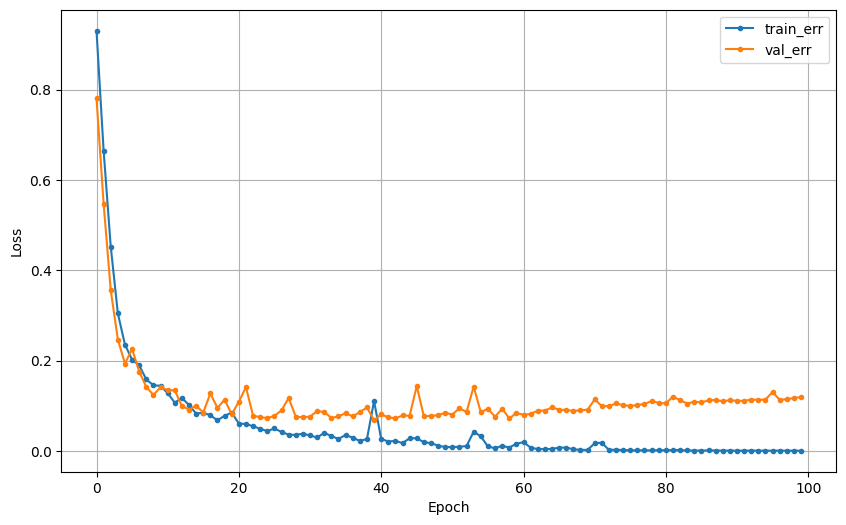

In [ ]:
dl_history_plot(history3)

In [ ]:
pred3 = model3.predict(x_test)
pred3 = pred3.argmax(axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
print(confusion_matrix(y_test,pred3))
print(classification_report(y_test,pred3))

[[216   0   7]
 [  0 217   0]
 [  6   0 201]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       223
           1       1.00      1.00      1.00       217
           2       0.97      0.97      0.97       207

    accuracy                           0.98       647
   macro avg       0.98      0.98      0.98       647
weighted avg       0.98      0.98      0.98       647



# (1)-2 정적모델 2

In [ ]:
clear_session()

model5 = Sequential([Input(shape=(nfeatures,)),
                           Dense(32,activation='relu'),
                           Dense(16,activation='relu'),
                          Dense(8,activation='relu'),
                          Dense(3,activation='softmax')])

model5.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          17,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,675 (72.95 KB)

 Trainable params: 18,675 (72.95 KB)

 Non-trainable params: 0 (0.00 B)

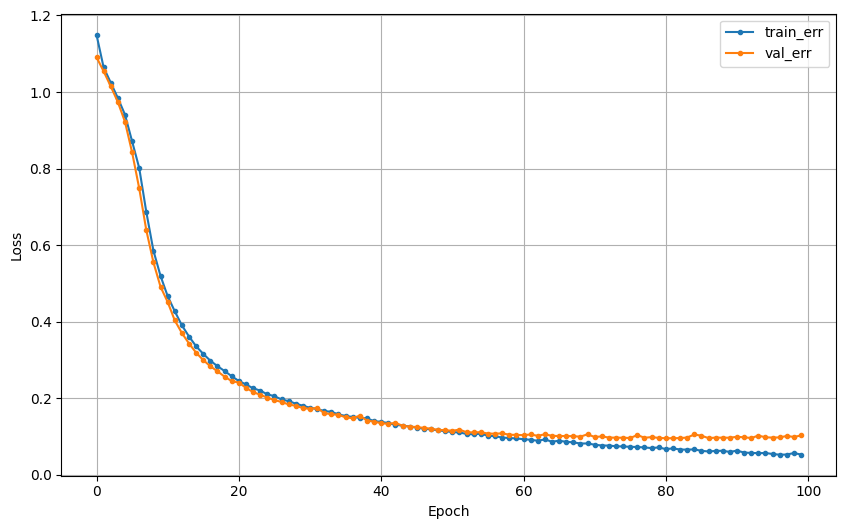

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
history5 = model5.fit(x_train,y_train,epochs=100,validation_split=0.2,verbose=0).history
dl_history_plot(history5)
pred5 = model5.predict(x_test)
pred5 = pred5.argmax(axis=1)

In [ ]:
print(confusion_matrix(y_test,pred5))
print(classification_report(y_test,pred5))

[[209   0  14]
 [  0 217   0]
 [  5   0 202]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       223
           1       1.00      1.00      1.00       217
           2       0.94      0.98      0.96       207

    accuracy                           0.97       647
   macro avg       0.97      0.97      0.97       647
weighted avg       0.97      0.97      0.97       647



# (1)-3 모델 3

In [ ]:
clear_session()

model6 = Sequential([Input(shape=(nfeatures,)),
                           Dense(512,activation='relu'),
                          Dropout(0.2),
                           Dense(256,activation='relu'),
                           Dense(128,activation='relu'),
                            Dropout(0.2),
                           Dense(64,activation='relu'),
                           Dense(32,activation='relu'),
                           Dense(16,activation='relu'),
                          Dense(8,activation='relu'),
                          Dense(3,activation='softmax')])

model6.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,995 (1.77 MB)

 Trainable params: 462,995 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

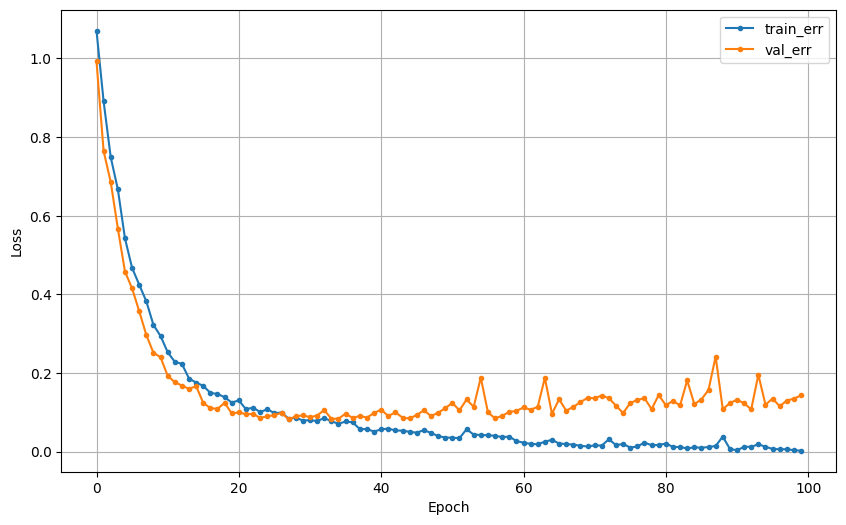

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
history6 = model6.fit(x_train,y_train,epochs=100,validation_split=0.2,verbose=0).history
dl_history_plot(history6)
pred6 = model6.predict(x_test)
pred6 = pred6.argmax(axis=1)

In [ ]:
print(confusion_matrix(y_test,pred6))
print(classification_report(y_test,pred6))

[[214   0   9]
 [  0 217   0]
 [  4   0 203]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       223
           1       1.00      1.00      1.00       217
           2       0.96      0.98      0.97       207

    accuracy                           0.98       647
   macro avg       0.98      0.98      0.98       647
weighted avg       0.98      0.98      0.98       647



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data01_train_dynamic = data01_train.loc[data01_train['is_dynamic']==1]

In [ ]:
x = data01_train_dynamic.drop(['Activity','is_dynamic'],axis=1)
y = data01_train_dynamic['Activity']
y = y.map({'WALKING_DOWNSTAIRS':0,'WALKING_UPSTAIRS':1,'WALKING':2})

In [ ]:
 y

,Activity
3,2
4,0
5,1
6,2
12,2
...,...
5868,2
5869,1
5873,2
5877,1


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=72)

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
nfeatures = x_train.shape[1]

#(2)-1 모델 동적

In [ ]:
clear_session()

model4 = Sequential([Input(shape=(nfeatures,)),
                           Dense(512,activation='relu'),
                           Dense(256,activation='relu'),
                           Dense(128,activation='relu'),
                           Dense(64,activation='relu'),
                           Dense(32,activation='relu'),
                           Dense(16,activation='relu'),
                          Dense(8,activation='relu'),
                          Dense(3,activation='softmax')])

model4.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,995 (1.77 MB)

 Trainable params: 462,995 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history4 = model4.fit(x_train,y_train,epochs=100,validation_split=0.2).history

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0395 - val_loss: 0.8584
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8041 - val_loss: 0.6195
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5672 - val_loss: 0.4383
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3696 - val_loss: 0.2480
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2476 - val_loss: 0.2037
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1454 - val_loss: 0.1103
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0946 - val_loss: 0.0656
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0604 - val_loss: 0.0507
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0604 - val_loss: 0.0414
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0574 - val_loss: 0.0386
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0301 - val_loss: 0.0291
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

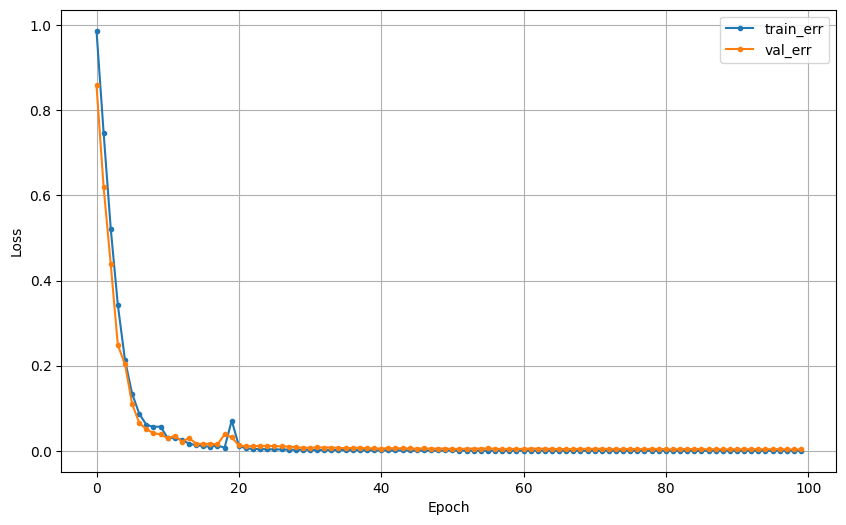

In [ ]:
dl_history_plot(history4)

In [ ]:
pred4 = model4.predict(x_test)
pred4 = pred4.argmax(axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
print(confusion_matrix(y_test,pred4))
print(classification_report(y_test,pred4))

[[165   0   0]
 [  0 168   0]
 [  0   0 197]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       168
           2       1.00      1.00      1.00       197

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



#(2)-2 모델 동적

In [ ]:
clear_session()

model7 = Sequential([Input(shape=(nfeatures,)),
                           Dense(32,activation='relu'),
                           Dense(16,activation='relu'),
                          Dense(8,activation='relu'),
                          Dense(3,activation='softmax')])

model7.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          17,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,675 (72.95 KB)

 Trainable params: 18,675 (72.95 KB)

 Non-trainable params: 0 (0.00 B)

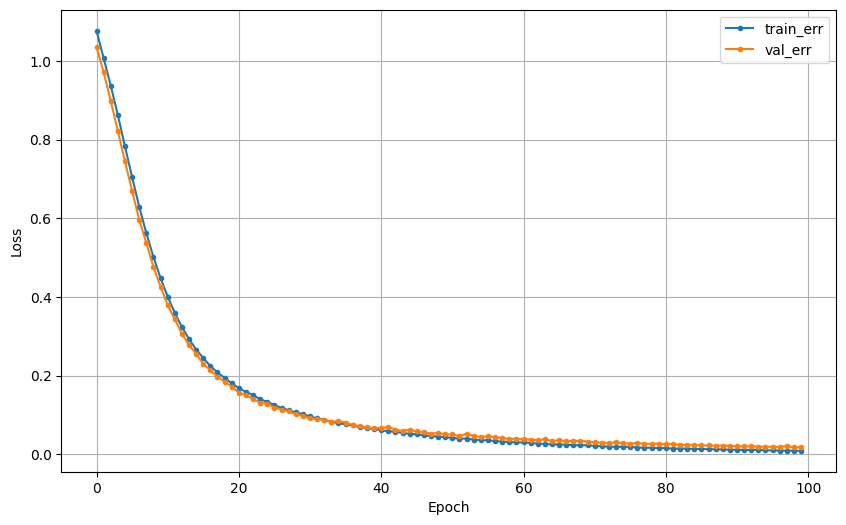

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
history7 = model7.fit(x_train,y_train,epochs=100,validation_split=0.2,verbose=0).history
dl_history_plot(history7)
pred7 = model7.predict(x_test)
pred7 = pred7.argmax(axis=1)

In [ ]:
print(confusion_matrix(y_test,pred7))
print(classification_report(y_test,pred7))

[[165   0   0]
 [  0 168   0]
 [  0   0 197]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       168
           2       1.00      1.00      1.00       197

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



#(2)-3 모델 동적

In [ ]:
clear_session()

model8 = Sequential([Input(shape=(nfeatures,)),
                           Dense(512,activation='relu'),
                          Dropout(0.2),
                           Dense(256,activation='relu'),
                           Dense(128,activation='relu'),
                            Dropout(0.2),
                           Dense(64,activation='relu'),
                           Dense(32,activation='relu'),
                           Dense(16,activation='relu'),
                          Dense(8,activation='relu'),
                          Dense(3,activation='softmax')])

model8.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

model8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,995 (1.77 MB)

 Trainable params: 462,995 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

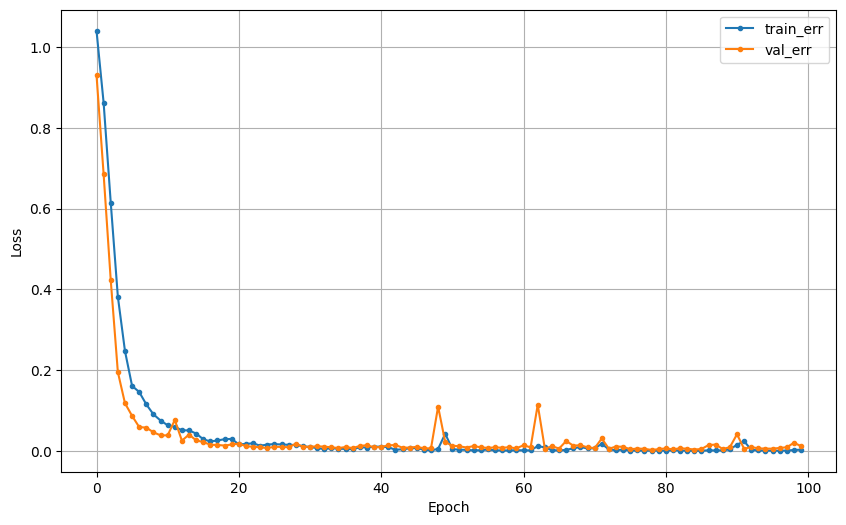

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
history8 = model8.fit(x_train,y_train,epochs=100,validation_split=0.2,verbose=0).history
dl_history_plot(history8)
pred8 = model8.predict(x_test)
pred8 = pred8.argmax(axis=1)

In [ ]:
print(confusion_matrix(y_test,pred8))
print(classification_report(y_test,pred8))

[[165   0   0]
 [  0 168   0]
 [  0   0 197]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       168
           2       1.00      1.00      1.00       197

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



#테스트 데이터로 검증

In [ ]:
data01_test_static = data01_test.loc[data01_test['is_dynamic']==0]
data01_test_dynamic = data01_test.loc[data01_test['is_dynamic']==1]

In [ ]:
data01_test_static

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.595825,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725,STANDING,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,0.281468,-0.017691,-0.111765,-0.997293,-0.994022,-0.996573,-0.997599,-0.994098,-0.996554,-0.941409,...,-0.543776,0.064921,0.000456,0.064799,0.023543,-0.237356,-0.235869,-0.372354,SITTING,0
1465,0.273755,-0.013503,-0.102659,-0.971087,-0.937989,-0.941491,-0.979173,-0.936476,-0.940864,-0.896707,...,-0.765217,-0.042466,0.231895,0.062831,0.119820,-0.594376,0.005538,-0.258097,SITTING,0
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,SITTING,0
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,STANDING,0


In [ ]:

x_1 = data01_test_static.drop(['Activity','is_dynamic'],axis=1)
y_1 = data01_test_static['Activity']
y_1 = y_1.map({'STANDING': 0 ,'LAYING':1,'SITTING':2})
scaler = MinMaxScaler()
x_1 = scaler.fit_transform(x_1)

x_2 = data01_test_dynamic.drop(['Activity','is_dynamic'],axis=1)
y_2 = data01_test_dynamic['Activity']
y_2 = y_2.map({'WALKING_DOWNSTAIRS':0,'WALKING_UPSTAIRS':1,'WALKING':2})
scaler = MinMaxScaler()
x_2 = scaler.fit_transform(x_2)

In [ ]:
pred_test_static = model6.predict(x_1)
pred_test_static =pred_test_static.argmax(axis=1)
print(confusion_matrix(y_1,pred_test_static))
print(classification_report(y_1,pred_test_static))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[276   0  11]
 [  0 291   1]
 [ 18   0 236]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       287
           1       1.00      1.00      1.00       292
           2       0.95      0.93      0.94       254

    accuracy                           0.96       833
   macro avg       0.96      0.96      0.96       833
weighted avg       0.96      0.96      0.96       833



In [ ]:
pred_test_dynamic = model7.predict(x_2)
pred_test_dynamic =pred_test_dynamic.argmax(axis=1)
print(confusion_matrix(y_2,pred_test_dynamic))
print(classification_report(y_2,pred_test_dynamic))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[194   0   1]
 [  1 208   6]
 [  0   0 228]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       195
           1       1.00      0.97      0.98       215
           2       0.97      1.00      0.98       228

    accuracy                           0.99       638
   macro avg       0.99      0.99      0.99       638
weighted avg       0.99      0.99      0.99       638



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
model2.save(path+'model2.h5')  #이진분류
model6.save(path+'model6.h5')  #정적 분류
model7.save(path+'model7.h5')  #동적분류

In [ ]:
model2 = keras.models.load_model(path+'model2.h5')
model6 = keras.models.load_model(path+'model6.h5')
model7 = keras.models.load_model(path+'model7.h5')
# model1_dh001.pkl(모델 불러오기가 꼭 필요합니다. (압축파일 내 존재))
model1 = joblib.load(path+'model1_dh001.pkl')

In [ ]:
data01_train.shape[0]

5881

In [ ]:
def preprocess(input_data):
  # model1_dh001 모델을 위한 데이터 전처리 과정
  # model1_dh001 : 정적, 동적 이진분류
  x_001 = input_data.drop('is_dynamic',axis=1)
  y_001 = input_data['is_dynamic']

  labels_is_dymanic_0 = ["tGravityAcc-max()-Y",
                        "tGravityAcc-min()-Y",
                        "tGravityAcc-max()-X",
                        "tGravityAcc-min()-X",
                        "tGravityAcc-mean()-Y",
                        "angle(Y,gravityMean)",
                        "tGravityAcc-energy()-X"]

  labels_is_dymanic_1 = ["tGravityAcc-arCoeff()-Y,2",
                        "tGravityAccMag-std()",
                        "tBodyAccMag-std()",
                        "fBodyAccMag-mad()",
                        "tGravityAcc-arCoeff()-Z,1",
                        "tBodyAcc-max()-X",
                        "tGravityAcc-arCoeff()-Z,3",
                        "fBodyAccMag-energy()",
                        "tBodyAccMag-mad()",
                        "fBodyAccMag-sma()",
                        "tGravityAccMag-arCoeff()1",
                        "tGravityAcc-arCoeff()-Y,3",
                        "fBodyAccMag-max()"]

  labels = []
  for lab in labels_is_dymanic_0:
    labels.append(lab)

  for lab in labels_is_dymanic_1:
    labels.append(lab)

  x_001 = x_001.loc[:, labels]

  scaler = MinMaxScaler()
  x_001 = scaler.fit_transform(x_001)
  return x_001, y_001

In [ ]:
def pipeline(data_copy,model_0_1,model_static,model_dynamic):
  data = data_copy.copy()
  data['is_dynamic'] = np.where(((data['Activity']=='STANDING')|(data['Activity']=='SITTING')|(data['Activity']=='LAYING')),
                              0,1)
  data.drop('subject', axis=1, inplace=True)                   #데이터 전처리

  #model1을 위한 데이터 전처리
  x_001, y_001 = preprocess(data)

  x = data.drop(['Activity','is_dynamic'],axis=1)
  scaler = MinMaxScaler()                   ##스케일링
  x = scaler.fit_transform(x)

  y = data['is_dynamic']


  pred0_1 = model_0_1.predict(x_001)                   #이진분류 예측
  pred0_1 = np.where(pred0_1>=0.5,1,0)
  indices = np.argmax(pred0_1, axis=1)
  df = pd.DataFrame({'index_column': indices})
  data['0_1_predict'] = df

  data_static = data.loc[data['0_1_predict']==0]       #카테고리 분류 예측
  data_dynamic = data.loc[data['0_1_predict']==1]


  x = data_static.drop(['Activity','is_dynamic','0_1_predict'],axis=1)     ##정적 예측
  scaler = MinMaxScaler()                   ##스케일링
  x = scaler.fit_transform(x)
  y = data_static['Activity']
  y = y.map({'STANDING': 0 ,'LAYING':1,'SITTING':2})
  pred_static = model_static.predict(x)
  pred_static = pred_static.argmax(axis=1)


  x = data_dynamic.drop(['Activity','is_dynamic','0_1_predict'],axis=1)     ##동적 예측
  scaler = MinMaxScaler()                   ##스케일링
  x = scaler.fit_transform(x)
  y = data_dynamic['Activity']
  y = y.map({'WALKING_DOWNSTAIRS':0,'WALKING_UPSTAIRS':1,'WALKING':2})
  pred_dynamic = model_dynamic.predict(x)
  pred_dynamic = pred_dynamic.argmax(axis=1)
  pred_dynamic = np.where(pred_dynamic==0,3,pred_dynamic)
  pred_dynamic = np.where(pred_dynamic==1,4,pred_dynamic)
  pred_dynamic = np.where(pred_dynamic==2,5,pred_dynamic)

  data_static['pred_activity'] = pred_static                  ## 두 데이터프레임 합치기
  data_dynamic['pred_activity'] = pred_dynamic


  data = pd.concat([data_static,data_dynamic])
  data['Activity'] = data['Activity'].map({'STANDING': 0 ,'LAYING':1,'SITTING':2,'WALKING_DOWNSTAIRS':3,'WALKING_UPSTAIRS':4,'WALKING':5})
  print(confusion_matrix(data['Activity'],data['pred_activity']))
  print(classification_report(data['Activity'],data['pred_activity']))
  print(accuracy_score(data['Activity'],data['pred_activity']))



In [ ]:
data01_train = pd.read_csv(path + 'data01_train.csv')

In [ ]:
pipeline(data01_train,model1,model6,model7)



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[1071    0   16    0    0    0]
 [   0 1114    1    0    0    0]
 [   8    0 1024    0    0    0]
 [   0    0    0  790    0    1]
 [   0    0    0    0  857    1]
 [   0    0    0    0    0  998]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1087
           1       1.00      1.00      1.00      1115
           2       0.98      0.99      0.99      1032
           3       1.00      1.00      1.00       791
           4       1.00      1.00      1.00       858
           5       1.00      1.00      1.00       998

    accuracy                           1.00      5881
   macro avg       1.00      1.00      1.00      5881
weighted avg       1.00      1.00      1.00      5881

0.9954089440571331


<ipython-input-635-0aa854196dda>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_static['pred_activity'] = pred_static                  ## 두 데이터프레임 합치기
<ipython-input-635-0aa854196dda>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dynamic['pred_activity'] = pred_dynamic


#### 2) test 셋으로 예측하고 평가하기

In [ ]:
data01_test = pd.read_csv(path + 'data01_test.csv')

In [ ]:
pipeline(data01_test,model1,model6,model7)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[278   0   9   0   0   0]
 [  0 292   0   0   0   0]
 [ 21   0 233   0   0   0]
 [  0   0   0 194   0   1]
 [  0   0   0   1 207   7]
 [  0   0   1   0   0 227]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       287
           1       1.00      1.00      1.00       292
           2       0.96      0.92      0.94       254
           3       0.99      0.99      0.99       195
           4       1.00      0.96      0.98       215
           5       0.97      1.00      0.98       228

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

0.972807613868117


<ipython-input-635-0aa854196dda>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_static['pred_activity'] = pred_static                  ## 두 데이터프레임 합치기
<ipython-input-635-0aa854196dda>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dynamic['pred_activity'] = pred_dynamic
